In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
%env DWAVE_API_TOKEN=DEV-a6b0d896430ef70f76c9622770293f0227d28aa4
!nvidia-smi
%config InlineBackend.figure_format = 'retina'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=DEV-a6b0d896430ef70f76c9622770293f0227d28aa4
Thu Feb 29 16:07:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   59C    P0   129W / 275W |  23999MiB / 81920MiB |     46%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+------------

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass
import h5py

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[16:08:05.743] INFO   CaloQVAE                                          Willkommen!
[16:08:05.744] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[16:08:06.253] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[16:08:06.255] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[16:08:06.255] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2024-02-29 16:08:06,670 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[16:08:06.670] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[16:08:08.572] INFO   data.dataManager                                  Loading Data
[16:08:15.149] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa777bbb250>: 80000 events, 625 batches
[16:08:15.150] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa777bbb450>: 10000 events, 10 batches
[16:08:15.151] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa777c18490>: 10000 events, 10 batches
[16:08:17.637] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-02-29 16:08:17

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[16:08:21.489] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[16:08:21.977] INFO   engine.engineAtlas                                Setting up engine Atlas.
[16:08:21.977] INFO   engine.engineCaloV3                               Setting up engine Calo.
[16:08:21.978] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[16:08:29.338] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa752b8dc90>: 80000 events, 625 batches
[16:08:29.339] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa6f6472710>: 10000 events, 10 batches
[16:08:29.339] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa752b8ca50>: 10000 events, 10 batches


In [10]:
###LOAD MODEL

In [11]:
# # apricot-terrain-235 <---- Fully connected NN
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/GumBoltAtlasPRBMFCN_atlas_default_latest.pth"
# modelname = 'apricot-terrain-235'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# happy-sun-270 | CNN + voxel pos enc + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'happy-sun-270'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True

    
# drawn-cosmos-266 | CNN + cond + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'drawn-cosmos-266'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    


# # misty-wind-267 | CNN + voxel pos enc JQTM + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'misty-wind-267'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

    
# # winter-glade-268 | CNN + cond pos enc + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'winter-glade-268'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    


# # prime-totem-282 | CNN + voxel pos enc + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'prime-totem-282'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  


# # smoldering-candles | CNN + cond + scaled data + no hits
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'smoldering-candles-302'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  
    
    
# # generous-elevator | CNN + cond + scaled data + no hits
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240216_200216-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'generous-elevator-301'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # skilled-spaceship-315 | CNN + cond + scaled data + no hits + interpolation 0
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
# modelname = 'skilled-spaceship-315'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-16/20-05-47/wandb/run-20240216_200548-u9ais1yt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # toasty-cherry-310 | CNN + cond + scaled data + hits dec uncond
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'toasty-cherry-310'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/22-10-50/wandb/run-20240215_221050-caevb6ld/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 
    
    
# # divine-valentine-309 | CNN + cond + scaled data + dec charm
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'divine-valentine-309'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-15/17-36-19/wandb/run-20240215_173620-l3i43zja/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True 



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[16:08:29.363] INFO   models.modelCreator                               Loading state
[16:08:29.497] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [72]:
# honest-blaze-275 | CNN + pions + scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'honest-blaze-275'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[14:34:36.861] INFO   models.modelCreator                               Loading state


GumBoltAtlasPRBMCNN
pion1
True False


[14:34:37.084] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [12]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [11]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

In [13]:
# beta effective method comparison
beta_comparison = {}
beta_comparison["Method 2 Adaptive"] = {"method" : 2, "adaptive" : True}
beta_comparison["Method 2 Fixed"] = {"method" : 2, "adaptive" : False}
# beta_comparison["Method 1 Adaptive"] = {"method" : 1, "adaptive" : True}
beta_comparison["Method 1 Fixed"] = {"method" : 1, "adaptive" : False}

In [14]:
def beta_est_stats(beta_comparison, sample_size = 20):
    for key in beta_comparison.keys():
        mthd = beta_comparison[key]["method"]
        adptv = beta_comparison[key]["adaptive"]
        print(mthd, adptv)
        for i in range(sample_size):
            print(i)
            beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.5, 
                                                                                                lr=0.01, num_epochs = 20, delta = 4.0, 
                                                                                                method = mthd, TOL=True, const = 1.0, 
                                                                                                    adaptive = adptv)
            beta_comparison[key][f'iteration_{i}'] = {"beta_list" : beta_list,
                                                      "beta" : beta,
                                                      "rbm_energy_list" : rbm_energy_list,
                                                      "dwave_energy_list" : dwave_energy_list,
                                                      "iterations" : len(beta_list),
                                                     }
        beta_comparison[key]["beta_mean"] = np.mean([beta_comparison[key][f'iteration_{i}']["beta"] for i in range(sample_size)])
        beta_comparison[key]["beta_std"] = np.std([beta_comparison[key][f'iteration_{i}']["beta"] for i in range(sample_size)])
        beta_comparison[key]["iteration_mean"] = np.mean([beta_comparison[key][f'iteration_{i}']["iterations"] for i in range(sample_size)])
        beta_comparison[key]["iteration_std"] = np.std([beta_comparison[key][f'iteration_{i}']["iterations"] for i in range(sample_size)])
    return beta_comparison
    

In [ ]:
beta_comparison = beta_est_stats(beta_comparison)

2 True
0


[16:08:51.368] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:08:53.742] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.293020182559298
[16:08:56.033] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.086567838659236
[16:08:58.234] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.024991349117584
[16:09:00.324] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.928234033188169
[16:09:01.996] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.891745511744232
[16:09:03.471] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.849604286998117


1


[16:09:07.185] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:09:08.844] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.189819652356857
[16:09:10.492] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.015957104034223
[16:09:12.089] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.940971817695859
[16:09:13.542] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8744198992606496


2


[16:09:17.249] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:09:18.703] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.15856909057557
[16:09:20.217] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.9534111914505665
[16:09:21.668] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8560350093517104
[16:09:23.275] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8175522562708832
[16:09:24.902] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.7798203002861794
[16:09:26.444] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.7337958538780733


3


[16:09:30.474] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:09:32.394] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.172882631562963
[16:09:33.919] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.8810391227008276
[16:09:35.478] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8193272276905024


4


[16:09:39.260] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:09:40.771] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.210404946529108
[16:09:42.237] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.993526403806879
[16:09:43.713] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8911115730681756
[16:09:45.293] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8381542486105507


5


[16:09:48.992] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:09:50.517] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.198882865904259
[16:09:52.021] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.970524236545661
[16:09:56.316] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.791114943268298
[16:09:57.768] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.830867027577134


6


[16:10:01.439] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:03.219] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.196830923025704
[16:10:04.864] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.014963339946174
[16:10:07.063] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.837068470983221
[16:10:08.566] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.5380830638151664
[16:10:10.067] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.509774038688896
[16:10:11.511] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.58331570397984
[16:10:13.002] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 3.6418547823547294


7


[16:10:17.008] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:18.463] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.249509994731367
[16:10:20.306] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.976454532248317
[16:10:21.779] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.874457586535931
[16:10:23.264] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.7930187070459964


8


[16:10:27.318] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:28.963] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.174285356873051
[16:10:30.681] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.000459289151002
[16:10:32.318] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.847030227322988
[16:10:33.799] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.732497781910827


9


[16:10:37.640] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:39.073] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.19999952317185
[16:10:40.695] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.9931355712576537
[16:10:42.213] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.9012436951416527


10


[16:10:45.980] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:47.503] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.224382973878961
[16:10:49.042] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.9660487105023585
[16:10:50.750] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8800107655200566
[16:10:52.262] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8530594452462923
[16:10:53.766] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.820278914068487


11


[16:10:57.495] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:10:59.125] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.131308521725975
[16:11:00.721] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.977785504557694
[16:11:02.255] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.881812916224587
[16:11:03.751] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8361935575870847
[16:11:05.237] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.793326899035195
[16:11:06.823] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.7695280168006344
[16:11:08.352] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 3.721891549162119
[16:11:09.890] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 3.753467652248385
[16:11:11.349] INFO   models.autoencoders.gumboltAtlasPRBM

12


[16:11:15.187] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:11:16.700] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.134362040130498
[16:11:18.229] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.8964313297118043
[16:11:19.767] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8457858787040937
[16:11:21.547] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.7867124478492724


13


[16:11:25.596] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:11:27.105] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.165957624987547
[16:11:28.563] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.9415847141933353
[16:11:30.125] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8296915223799015
[16:11:31.712] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.756218187277659
[16:11:33.292] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.7101558377385757
[16:11:34.833] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.683507199278436


14


[16:11:38.524] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:11:40.018] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.214515054295555
[16:11:41.516] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.000494190417044
[16:11:42.964] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8191826539832343


15


[16:11:46.611] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:11:48.092] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.188156240563676
[16:11:49.585] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.9522870056797825
[16:11:51.041] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8431001652782966
[16:11:52.750] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8101731254570157
[16:11:54.596] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.773171805561838


16


[16:11:58.261] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:11:59.915] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.234597828909766
[16:12:01.485] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.941302065047045
[16:12:03.047] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.8347070350010024
[16:12:04.503] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.7540742105350033
[16:12:06.001] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.7172467198281667


17


[16:12:09.740] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:12:11.503] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.231941585899625
[16:12:12.997] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.996276323826862
[16:12:14.524] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.908499767416363
[16:12:16.134] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8786789975191045
[16:12:17.604] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.8270450193385175
[16:12:19.564] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 3.7793997228600458


18


[16:12:23.158] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:12:24.680] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.105566099314201
[16:12:26.263] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 3.8782051708108063
[16:12:27.731] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 3.802690127139418


19


[16:12:44.141] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:12:45.981] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.204249556741992
[16:12:47.630] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.095552242482646
[16:12:49.145] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.00783047295012
[16:12:50.636] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 3.8943967005384814
[16:12:52.210] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 3.862310084284475


2 False
0


[16:12:57.649] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:12:59.602] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.443707878399975
[16:13:01.092] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.387512302239185
[16:13:02.658] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.340424035324394
[16:13:04.118] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.30404332679133
[16:13:05.600] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.270191969249726
[16:13:07.095] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.238593918838745
[16:13:08.689] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.2097586978142685
[16:13:10.246] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.180337826179806
[16:13:11.792] INFO   models.autoencoders.gumboltAtlasPRBMCN

1


[16:13:31.779] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:13:33.346] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.443972522000085
[16:13:34.842] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.395161213527018
[16:13:36.810] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.347904582862927
[16:13:38.743] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.301200268906164
[16:13:40.257] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.248352016145841
[16:13:41.742] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.214211732827833
[16:13:43.226] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.1846967735383185
[16:13:44.707] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.158070814484865
[16:13:46.239] INFO   models.autoencoders.gumboltAtlasPRBMC

2


[16:14:06.876] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:14:08.334] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.44935830037092
[16:14:09.824] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.395210979022867
[16:14:11.868] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.355130375345096
[16:14:13.362] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.3137717202273
[16:14:14.917] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.277747269932869
[16:14:16.486] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.248126192523074
[16:14:17.947] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.21922108499287
[16:14:19.567] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.1927448897687265
[16:14:21.093] INFO   models.autoencoders.gumboltAtlasPRBMCNN  

3


[16:14:41.594] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:14:43.233] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.447935086159317
[16:14:45.468] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.3878439135120715
[16:14:46.988] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.341712050361288
[16:14:48.487] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.298666080091311
[16:14:49.945] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.2624449361088494
[16:14:51.398] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.220401731223645
[16:14:52.844] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.187453290125624
[16:14:54.358] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.156566762364195
[16:14:55.840] INFO   models.autoencoders.gumboltAtlasPRBM

4


[16:15:16.522] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:15:18.246] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.449609366109714
[16:15:19.723] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.398554456578977
[16:15:21.339] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.349108467364042
[16:15:23.100] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.3062557311715
[16:15:24.614] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.270117545911757
[16:15:26.101] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.228209866882754
[16:15:27.567] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.195458033130161
[16:15:29.166] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.166126159703702
[16:15:30.664] INFO   models.autoencoders.gumboltAtlasPRBMCNN 

5


[16:15:51.053] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:15:52.722] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.442119202490877
[16:15:54.155] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.383502101621532
[16:15:55.676] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.332596512534114
[16:15:57.121] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.285987984426997
[16:15:58.690] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.242712557557687
[16:16:00.156] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.20248475540447
[16:16:01.941] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.1652752690059565
[16:16:03.410] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.131788781514964
[16:16:04.999] INFO   models.autoencoders.gumboltAtlasPRBMCN

6


[16:16:27.700] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:16:29.271] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.451151100091557
[16:16:30.723] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.398258664754642
[16:16:32.290] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.35955951664183
[16:16:33.777] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.309409037067328
[16:16:35.278] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.267791959294367
[16:16:36.781] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.2334013964396755
[16:16:38.240] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.194637980565747
[16:16:39.685] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.167769616893178
[16:16:41.179] INFO   models.autoencoders.gumboltAtlasPRBMCN

7


[16:17:02.095] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:17:03.574] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.449749797342765
[16:17:05.213] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.404161822148449
[16:17:06.727] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.356599068425231
[16:17:08.289] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.316902551819491
[16:17:09.876] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.278403953630107
[16:17:11.367] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.250041832324116
[16:17:12.977] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.212382077849984
[16:17:14.459] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.181017052884549
[16:17:16.108] INFO   models.autoencoders.gumboltAtlasPRBMCN

8


[16:17:47.214] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:17:48.930] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.453260594096137
[16:17:51.919] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.396329028077367
[16:17:53.403] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.352255727870397
[16:17:54.907] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.311006793274246
[16:17:56.392] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.277881342413862
[16:17:57.881] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.245026649728454
[16:17:59.352] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.211092158025344
[16:18:00.850] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.172059415913962
[16:18:02.391] INFO   models.autoencoders.gumboltAtlasPRBMCN

9


[16:18:32.127] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:18:33.585] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.452064199729822
[16:18:35.091] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.410404726447543
[16:18:36.572] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.371410687662662
[16:18:38.099] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.330191314804736
[16:18:39.584] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.285765732595589
[16:18:41.722] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.253157301324835
[16:18:43.203] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.221640932615367
[16:18:44.676] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.190454192718511
[16:18:46.179] INFO   models.autoencoders.gumboltAtlasPRBMCN

10


[16:19:06.876] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 0: beta = 4.5
[16:19:08.343] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 1: beta = 4.4450237733373426
[16:19:09.794] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 2: beta = 4.3922356578105
[16:19:11.281] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 3: beta = 4.344978281941368
[16:19:12.892] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 4: beta = 4.298418435151797
[16:19:14.395] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 5: beta = 4.266546294002782
[16:19:15.973] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 6: beta = 4.2321243152052315
[16:19:17.554] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 7: beta = 4.1949731434190065
[16:19:19.038] INFO   models.autoencoders.gumboltAtlasPRBMCNN           Epoch 8: beta = 4.166600851402574
[16:19:20.538] INFO   models.autoencoders.gumboltAtlasPRBMC

In [16]:
# beta_comparison

In [17]:
# beta_comparison["Method 2 Adaptive"]
print(beta_comparison["Method 2 Adaptive"]["beta_mean"], beta_comparison["Method 2 Adaptive"]["beta_std"], 
      beta_comparison["Method 2 Adaptive"]["iteration_mean"], beta_comparison["Method 2 Adaptive"]["iteration_std"])
print(beta_comparison["Method 2 Fixed"]["beta_mean"], beta_comparison["Method 2 Fixed"]["beta_std"],
     beta_comparison["Method 2 Fixed"]["iteration_mean"], beta_comparison["Method 2 Fixed"]["iteration_std"])
print(beta_comparison["Method 1 Fixed"]["beta_mean"], beta_comparison["Method 1 Fixed"]["beta_std"],
     beta_comparison["Method 1 Fixed"]["iteration_mean"], beta_comparison["Method 1 Fixed"]["iteration_std"])

3.78559639818934 0.05508638813640641 6.4 1.7146428199482249


KeyError: 'beta_mean'

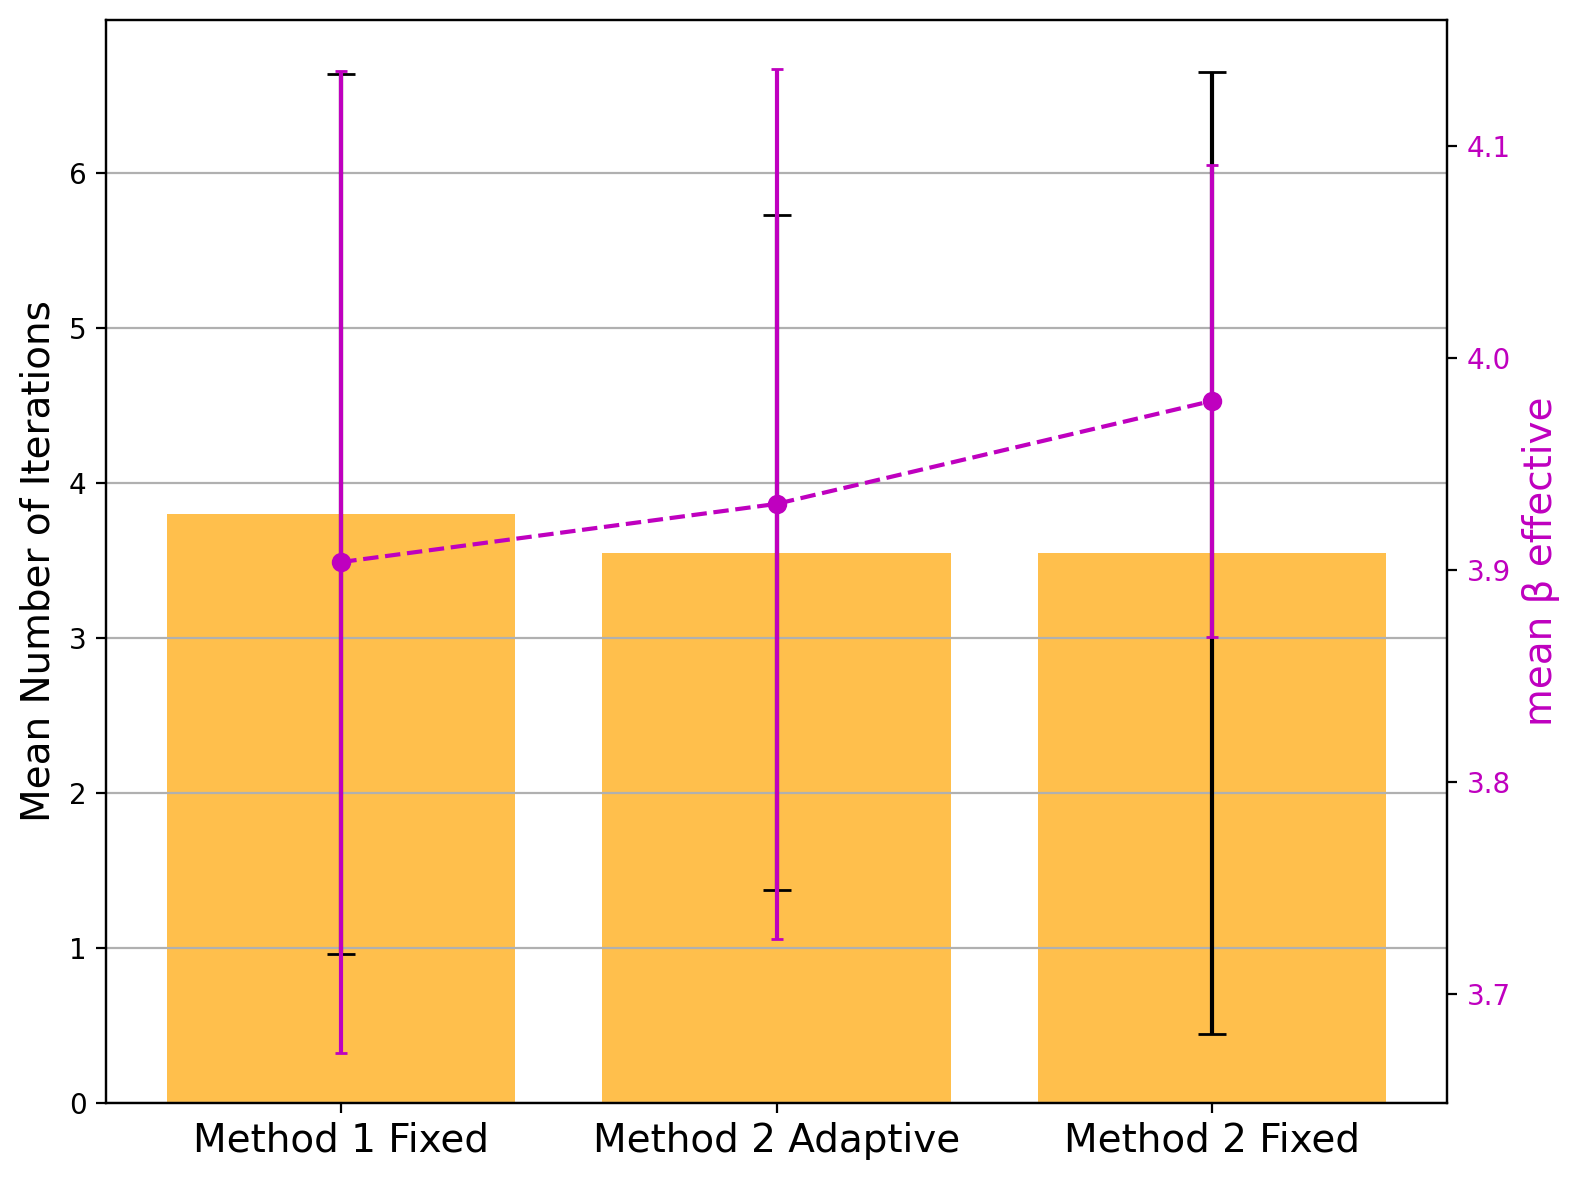

In [167]:

# plt.figure()
groups = list(np.sort([key for key in beta_comparison.keys() if key != "modelname"]))
means = [beta_comparison[key]["iteration_mean"] for key in groups]
std_devs = [beta_comparison[key]["iteration_std"] for key in groups]

# Additional data for the overlay plot
# For simplicity, let's use some random values for "Metric B" and its errors
metric_b_values = [beta_comparison[key]["beta_mean"] for key in groups ]
metric_b_errors = [beta_comparison[key]["beta_std"] for key in groups ]

# Create the bar plot
fig, ax1 = plt.subplots(figsize=(8,6))

positions = np.arange(len(groups))
width = 0.8  # Width of the bars

bar_plot = ax1.bar(positions, means, width, yerr=std_devs, alpha=0.7, color='orange', capsize=5)

# Set labels and aesthetics for the first y-axis
ax1.set_ylabel('Mean Number of Iterations', fontsize=14)
ax1.set_xticks(positions)
ax1.set_xticklabels(groups, fontsize=14, rotation=0)  # Rotation for better label readability
ax1.yaxis.grid(True)

# Create a second y-axis for the overlay plot
ax2 = ax1.twinx()

# Plot the data for "Metric B" on the second y-axis with error bars
line_plot = ax2.errorbar(positions, metric_b_values, yerr=metric_b_errors, fmt='--o', color='m', capsize=2)

# Set the label for the second y-axis
ax2.set_ylabel('mean β effective', color='m', fontsize=14)
ax2.tick_params(axis='y', labelcolor='m')  # Set the color of the second y-axis ticks and label to red

# Optionally, you can create a combined legend for both plots
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()  # Adjust the layout to make room for the labels
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/beta_comparison_plot_{modelname}.png', dpi=300)
plt.show()



In [181]:
print([np.mean([np.abs(beta_comparison[mthd][f'iteration_{i}']['beta'] - 4)/beta_comparison[mthd][f'iteration_{i}']['iterations'] for i in range(20)]) for mthd in groups])
print([np.std([np.abs(beta_comparison[mthd][f'iteration_{i}']['beta'] - 4)/beta_comparison[mthd][f'iteration_{i}']['iterations'] for i in range(20)]) for mthd in groups])
print(groups)
    

[0.0184971415201823, 0.020822142105832806, 0.004432515591899242]
[0.026421768707372253, 0.025593344090970856, 0.006495744779569644]
['Method 1 Fixed', 'Method 2 Adaptive', 'Method 2 Fixed']


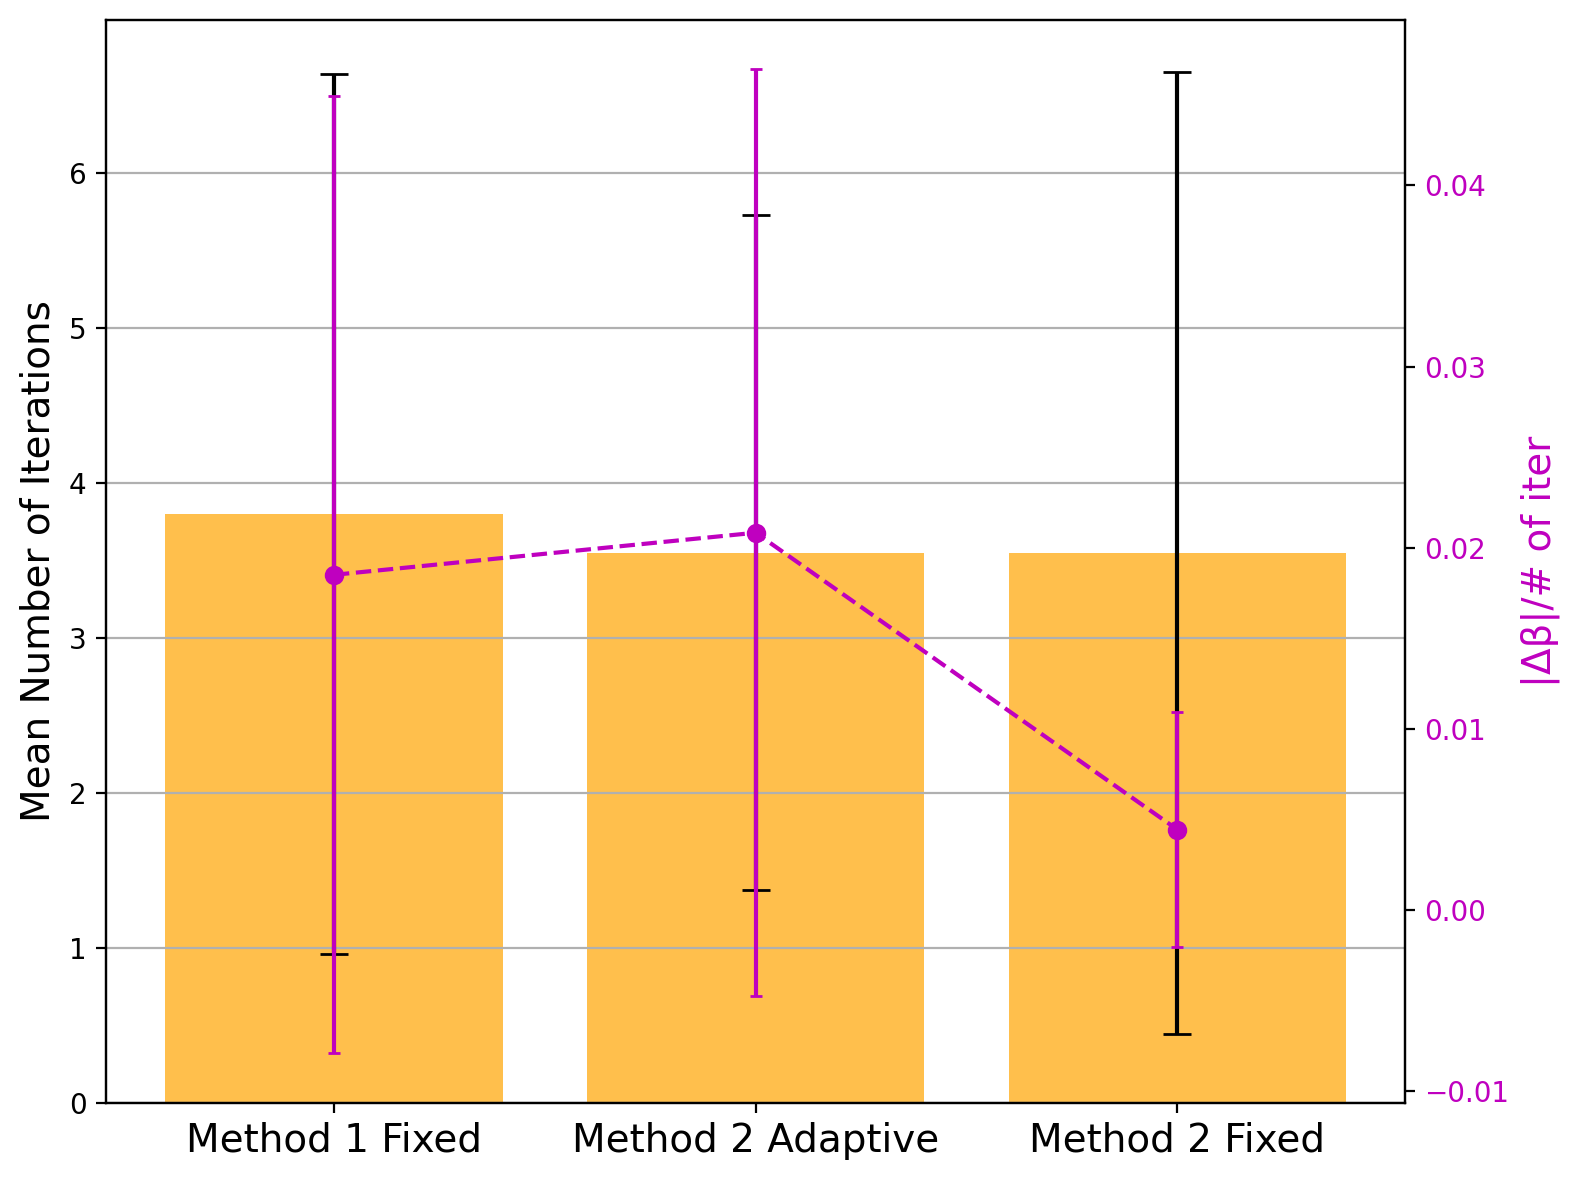

In [184]:

# plt.figure()
groups = list(np.sort([key for key in beta_comparison.keys() if key != "modelname"]))
means = [beta_comparison[key]["iteration_mean"] for key in groups]
std_devs = [beta_comparison[key]["iteration_std"] for key in groups]

# Additional data for the overlay plot
# For simplicity, let's use some random values for "Metric B" and its errors
metric_b_values = [np.mean([np.abs(beta_comparison[mthd][f'iteration_{i}']['beta'] - 4)/beta_comparison[mthd][f'iteration_{i}']['iterations'] for i in range(20)]) for mthd in groups]
metric_b_errors = [np.std([np.abs(beta_comparison[mthd][f'iteration_{i}']['beta'] - 4)/beta_comparison[mthd][f'iteration_{i}']['iterations'] for i in range(20)]) for mthd in groups]

# Create the bar plot
fig, ax1 = plt.subplots(figsize=(8,6))

positions = np.arange(len(groups))
width = 0.8  # Width of the bars

bar_plot = ax1.bar(positions, means, width, yerr=std_devs, alpha=0.7, color='orange', capsize=5)

# Set labels and aesthetics for the first y-axis
ax1.set_ylabel('Mean Number of Iterations', fontsize=14)
ax1.set_xticks(positions)
ax1.set_xticklabels(groups, fontsize=14, rotation=0)  # Rotation for better label readability
ax1.yaxis.grid(True)

# Create a second y-axis for the overlay plot
ax2 = ax1.twinx()

# Plot the data for "Metric B" on the second y-axis with error bars
line_plot = ax2.errorbar(positions, metric_b_values, yerr=metric_b_errors, fmt='--o', color='m', capsize=2)

# Set the label for the second y-axis
ax2.set_ylabel('|Δβ|/# of iter', color='m', fontsize=14)
ax2.tick_params(axis='y', labelcolor='m')  # Set the color of the second y-axis ticks and label to red

# Optionally, you can create a combined legend for both plots
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()  # Adjust the layout to make room for the labels
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/beta_comparison_plot_{modelname}_2.png', dpi=300)
plt.show()



In [35]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


In [41]:
beta_comparison["Method 2 Adaptive"][f'iteration_{1}']['beta']

4.366710008240851

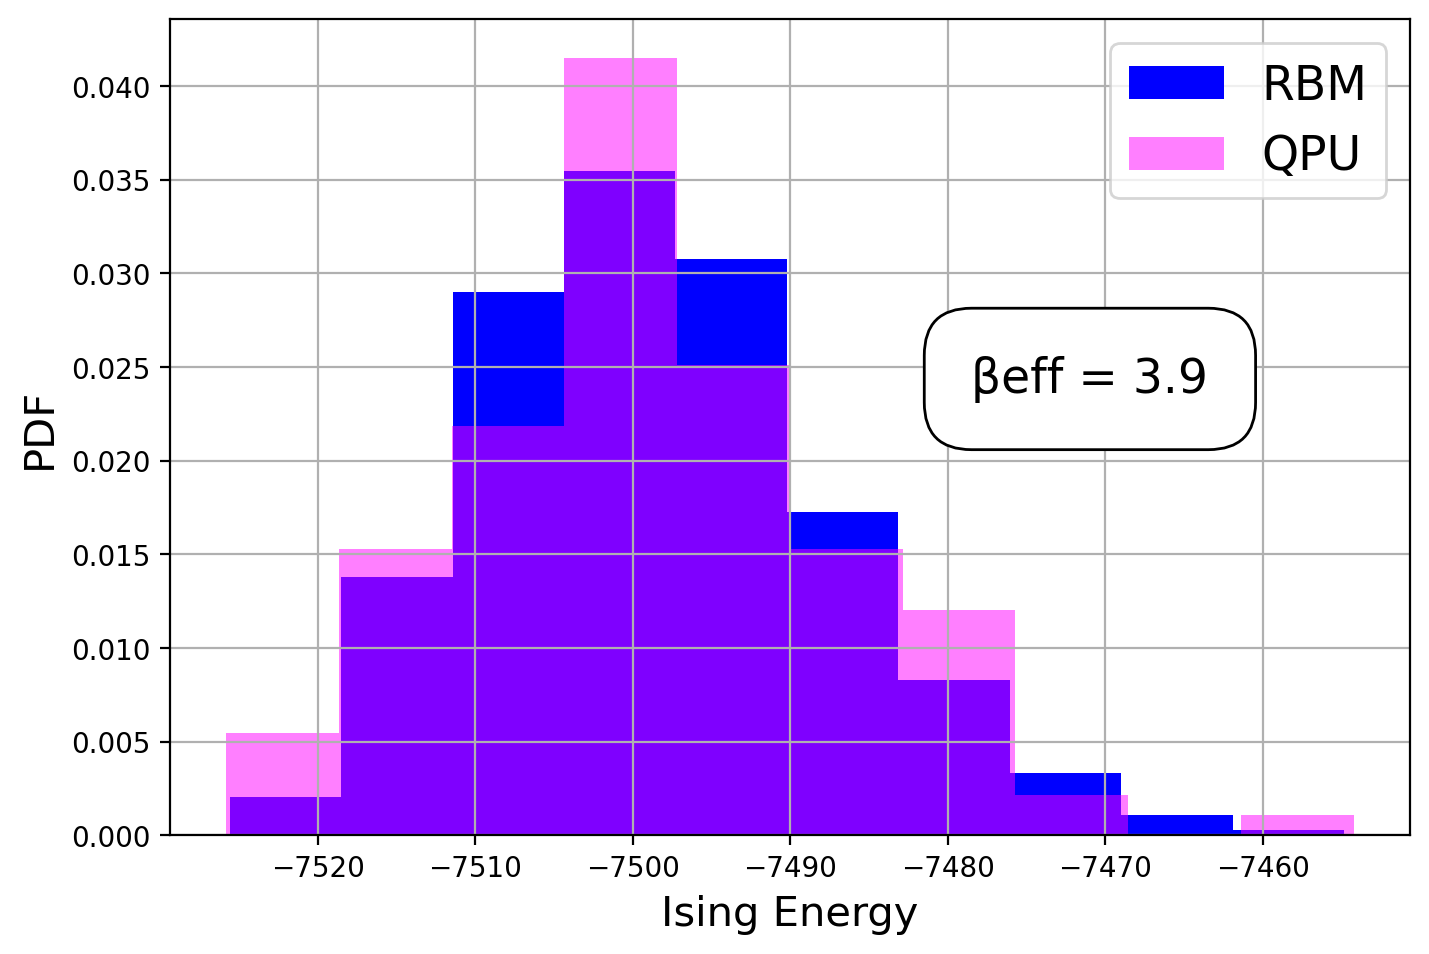

In [187]:
it = 8
beta = beta_comparison["Method 2 Adaptive"][f'iteration_{it}']['beta']
plt.figure(figsize=(8,6))
plt.hist(beta_comparison["Method 2 Adaptive"][f'iteration_{it}']['rbm_energy_list'][-1] + Hoffset, density=True, color="b")
plt.hist(beta_comparison["Method 2 Adaptive"][f'iteration_{it}']['dwave_energy_list'][-1] + Hoffset, density=True, fc=(1, 0, 1, 0.5))
plt.xlabel("Ising Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["RBM", "QPU"], fontsize=17)
plt.figtext(0.7, 0.6, f'βeff = {np.round(beta, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [188]:
# beta_comparison

beta_comparison['modelname'] = modelname
with open(f'/home/javier/Projects/CaloQVAE/figs/beta_comparison_{modelname}.pickle', 'wb') as handle:
    pickle.dump(beta_comparison, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
#############LOAD

In [62]:
# Loading the dictionary from the file
with open('/home/javier/Projects/CaloQVAE/figs/beta_comparison.pickle', 'rb') as handle:
    loaded_data = pickle.load(handle)

In [63]:
loaded_data.keys()

dict_keys(['Method 2 Adaptive', 'Method 2 Fixed', 'Method 1 Fixed', 'modelname'])

In [64]:
loaded_data['modelname']

'generous-elevator-301'

In [113]:
#################Load synthetic and test data

In [1]:
def load_hdf5_file(file_path):
    data_dict = {}
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as file:
        # List all groups
        print("Keys: %s" % file.keys())
        for key in file.keys():
            data_dict[key] = torch.tensor(file[key][:])

        a_group_key = list(file.keys())[0]
    return data_dict

In [9]:
# Replace 'your_file.h5' with the path to your HDF5 file
file_path = '/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic_nohits.hdf5'
data_dict = {}
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict[key] = torch.tensor(file[key][:])
        
    a_group_key = list(file.keys())[0]

    # Get the data
    # data = list(file[a_group_key])

    # If you know the specific dataset you want to access, you can use
    # dataset = file['dataset_name']  # 'dataset_name' is the name of your dataset
    # data = dataset[:]  # Read the entire dataset

    # Now, 'data' is a NumPy array containing the dataset's contents


Keys: <KeysViewHDF5 ['incidence energy', 'showers']>


In [10]:
data_syn = load_hdf5_file('/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic.hdf5')
data_syn_nohits = load_hdf5_file('/raid/javier/Datasets/CaloVAE/data/synData/dataset2_synthetic_nohits.hdf5')
data_test = load_hdf5_file('/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_2.hdf5')

Keys: <KeysViewHDF5 ['incidence energy', 'showers']>
Keys: <KeysViewHDF5 ['incidence energy', 'showers']>
Keys: <KeysViewHDF5 ['incident_energies', 'showers']>


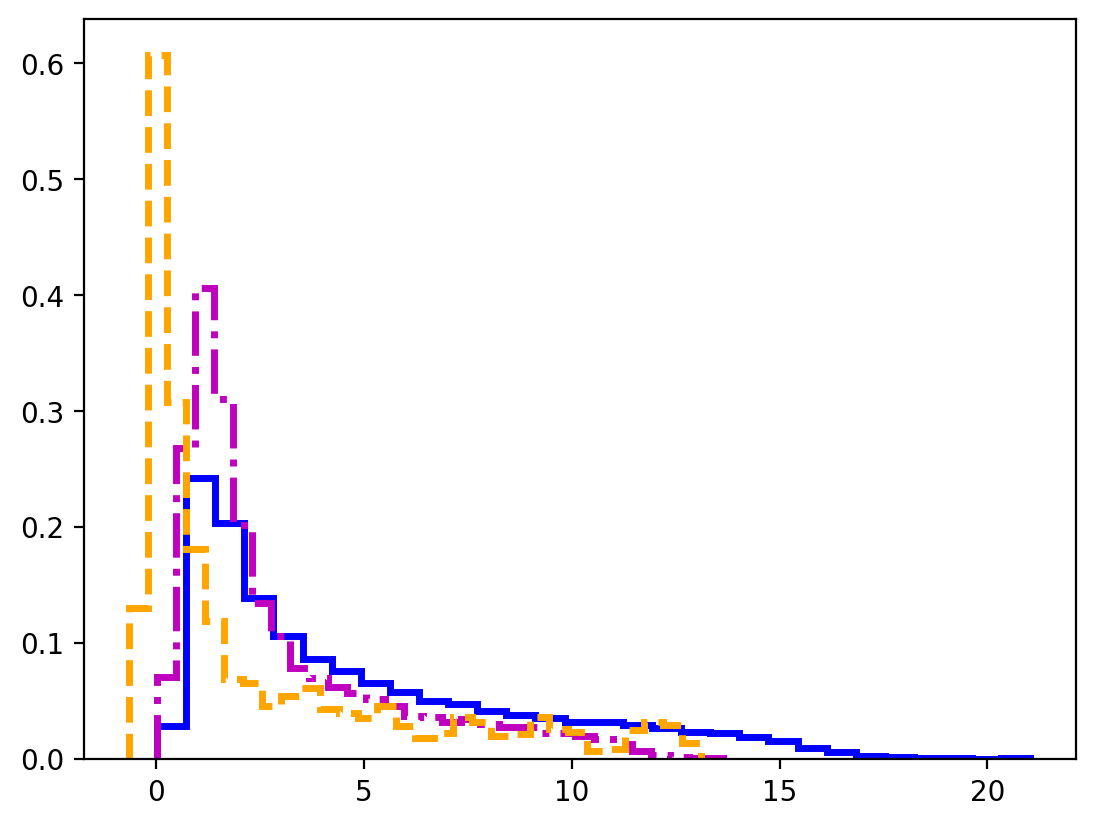

torch.Size([44254])


In [159]:
data_test.keys()
E_right = 20000
E_left = 0
tmp = (data_test['incident_energies'] < E_right) * (data_test['incident_energies'] > E_left)
idxEnFilter_test = (tmp == True).nonzero(as_tuple=True)[0]

tmp = (data_syn['incidence energy'] < E_right) * (data_syn['incidence energy'] > E_left)
idxEnFilter_syn = (tmp == True).nonzero(as_tuple=True)[0]

tmp = (data_syn_nohits['incidence energy'] < E_right) * (data_syn_nohits['incidence energy'] > E_left)
idxEnFilter_syn_nohits = (tmp == True).nonzero(as_tuple=True)[0]

plt.hist(data_test['showers'][idxEnFilter_test,:].sum(dim=1).numpy()/1000, bins=30, density=True, log=False, histtype='step', linewidth=2.5, color="b")
plt.hist(data_syn['showers'][idxEnFilter_syn,:].sum(dim=1).numpy()/1000 , bins=30, density=True, log=False, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(data_syn_nohits['showers'][idxEnFilter_syn_nohits,:].sum(dim=1).numpy()/1000 , bins=30, density=True, log=False, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")

plt.show()
print(idxEnFilter_syn.shape)

In [157]:
data_syn['showers'].sum(dim=1).shape

torch.Size([100000])

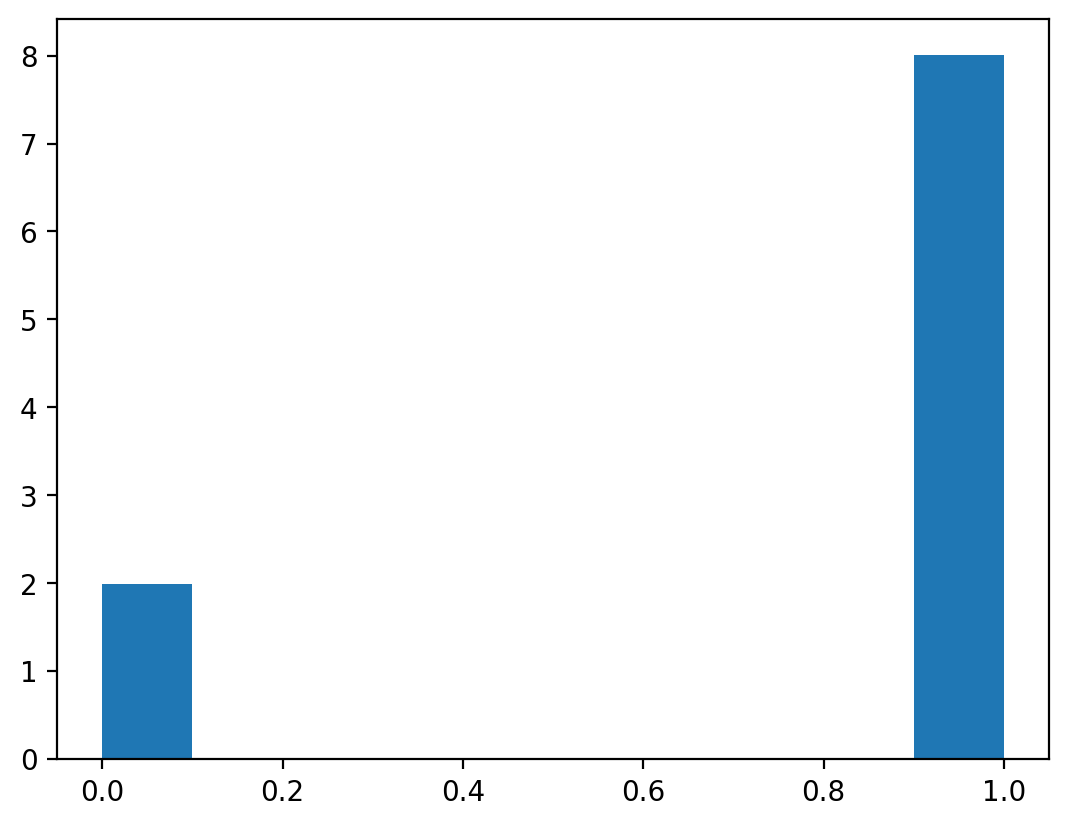

In [16]:
plt.hist(data_test['showers'].sign()[100,:].numpy(), density=True)
plt.show()